# Evaluation of the image recognition algorithm

Problem description: 

There is a process for detection of traffic violations generated by photo and video cameras. Cameras detect various violations and generate violation materials, while recognizing the registration plate (SRP, state registration plate) of the vehicle. After that, all violations are analyzed by a competent employee (operator) and a decision is made: to issue a violation, or reject for some reason. If the SRP is recognized by the camera incorrectly, then the employee can correct the SRP but it requires additional effort and time from the employee. An additional mathematical algorithm of the image processing (AI) has been introduced into the existing process before the material is transferred to the operator. It is expected that the use of the new algorithm will reduce the number of corrections of the SRP by the operator.

This requires:
1. Define conditions according to which it is necessary to change the SRP from the recognized one by the camera to the one recognized by the new mathematical algorithm.
2. Evaluate the quality of the rule, indicate the savings in replacement operations.

Data description:
- id              --violation identifier
- camera_id       --camera identifier
- time_check      --violation fixation time
- regno_recognize --SRP recognized by the camera
- regno_ai        --SRP recognized by the new algorithm
- regno           --SRP processing by operator
- symbols         --SRP recognized by the new algorithm by symbol
- symbol_scores   --confidence score of the new algorithm for each symbol (0...1)
- length_scores   --confidence score of the length of SRP, starting from length 0 up to length 10 characters (0...1)
- result_code     --final code violation


result_code description:
- 0 - accepted
- 1 - rejected "SRP is poorly visible"
- 2 - rejected "error in the owner's address"
- 3 - rejected "error in other data of the owner"
- 4 - rejected "poor image quality"
- 5 - rejected "other"

## 1. Data Load & Preview

In [1]:
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def min_score(list_scores):
    f = []
    for score in list_scores:
        f.append(float(score))
    return min(f)

In [3]:
def max_score(list_scores):
    f = []
    for score in list_scores:
        f.append(float(score))
    return max(f)

In [4]:
data = pd.read_csv('data_regno.csv', delimiter=';', index_col='id')
data.head()

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,symbols,symbol_scores,length_scores
id,,,,,,,,,
1,844,00:00:00,У991КВ799,У991КВ799,У991КВ799,0,"[""У"", ""9"", ""9"", ""1"", ""К"", ""В"", ""7"", ""9"", ""9""]","[0.9999366998672485, 0.9999223947525024, 0.999...","[0.000000034831597162110484, 0.000000034835451..."
2,2516,00:00:00,О019УК177,О019УК177,О019УК177,0,"[""О"", ""0"", ""1"", ""9"", ""У"", ""К"", ""1"", ""7"", ""7""]","[0.9998993873596191, 0.999862790107727, 0.9999...","[0.0000000068477667980459955, 0.00000000683332..."
3,2476,00:00:00,Е175АК150,Е175АК150,Е175АК150,0,"[""Е"", ""1"", ""7"", ""5"", ""А"", ""К"", ""1"", ""5"", ""0""]","[0.9997256398200989, 0.9999269247055054, 0.999...","[0.000000002039653557162069, 0.000000002043387..."
4,1251,00:00:01,Т359ОН799,Т359ОН799,Т359ОН799,0,"[""Т"", ""3"", ""5"", ""9"", ""О"", ""Н"", ""7"", ""9"", ""9""]","[0.9998781681060791, 0.9998764991760254, 0.999...","[0.00000002880540606042814, 0.0000000289985120..."
5,2516,00:00:01,В521СУ750,В521СУ750,В521СУ750,0,"[""В"", ""5"", ""2"", ""1"", ""С"", ""У"", ""7"", ""5"", ""0""]","[0.999920129776001, 0.9999333620071411, 0.9999...","[0.000000009300508807541519, 0.000000009201486..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194214 entries, 1 to 194214
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   camera_id        194214 non-null  int64 
 1   time_check       194214 non-null  object
 2   regno_recognize  194214 non-null  object
 3   regno_ai         194214 non-null  object
 4   regno            194214 non-null  object
 5   result_code      194214 non-null  int64 
 6   symbols          194214 non-null  object
 7   symbol_scores    194214 non-null  object
 8   length_scores    194214 non-null  object
dtypes: int64(2), object(7)
memory usage: 14.8+ MB


Let's build a countplot so see how the result_codes is distributed.

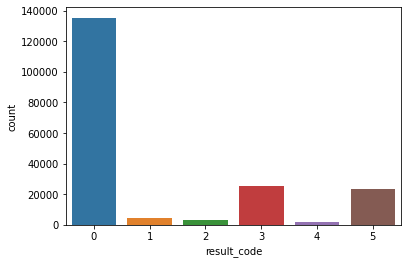

In [6]:
sns.countplot(data['result_code']);

### Cameras errors VS AI errors

In [7]:
data.loc[data['regno_recognize']!=data['regno'], 'error_cam']=1   # cameras errors
data.loc[data['regno_ai']!=data['regno'], 'error_ai']=1           # ai errors
data.fillna(0, inplace=True)
data.head(2)

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,symbols,symbol_scores,length_scores,error_cam,error_ai
id,,,,,,,,,,,
1,844,00:00:00,У991КВ799,У991КВ799,У991КВ799,0,"[""У"", ""9"", ""9"", ""1"", ""К"", ""В"", ""7"", ""9"", ""9""]","[0.9999366998672485, 0.9999223947525024, 0.999...","[0.000000034831597162110484, 0.000000034835451...",0.0,0.0
2,2516,00:00:00,О019УК177,О019УК177,О019УК177,0,"[""О"", ""0"", ""1"", ""9"", ""У"", ""К"", ""1"", ""7"", ""7""]","[0.9998993873596191, 0.999862790107727, 0.9999...","[0.0000000068477667980459955, 0.00000000683332...",0.0,0.0


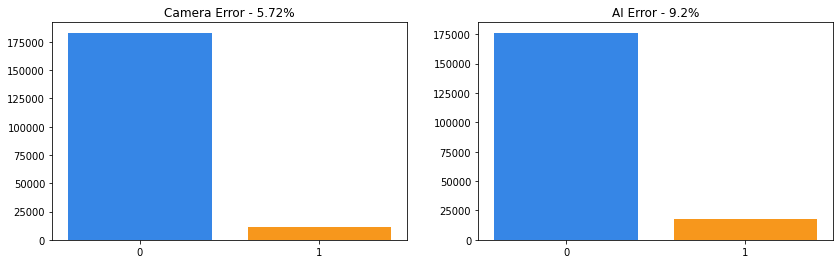

In [8]:
er_cam = round(((data.loc[data['error_cam']==1]).shape[0]/data.shape[0])*100, 2)
er_ai = round(((data.loc[data['error_ai']==1]).shape[0]/data.shape[0])*100, 2)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].bar(data['error_cam'].value_counts().index, data['error_cam'].value_counts().values, 
          color=['#3686e6', '#f7971c']) 
ax[0].xaxis.set(ticks=[0, 1])
ax[0].set(title=f'Camera Error - {er_cam}%')

ax[1].bar(data['error_ai'].value_counts().index, data['error_ai'].value_counts().values, 
          color=['#3686e6', '#f7971c'])
ax[1].xaxis.set(ticks=[0, 1])
ax[1].set(title=f'AI Error - {er_ai}%')

plt.show()

At first sight, the accuracy of the new algorithm is even slightly worse than the accuracy of SRP recognition by cameras.

## 2. Data analysis

For a start, we can see how the accuracy of the new algorithm depends on the image quality compared to the accuracy of the camera.

### image quality

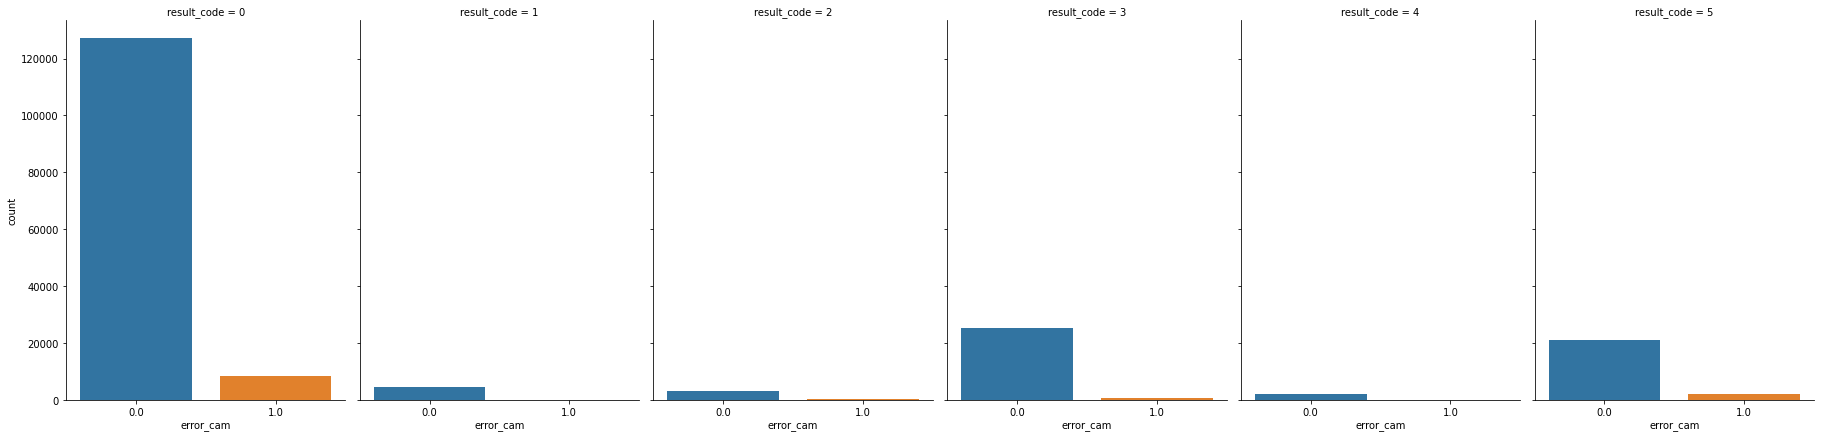

In [9]:
sns.catplot(x="error_cam", col="result_code", data=data, kind="count", height=6, aspect=0.7);

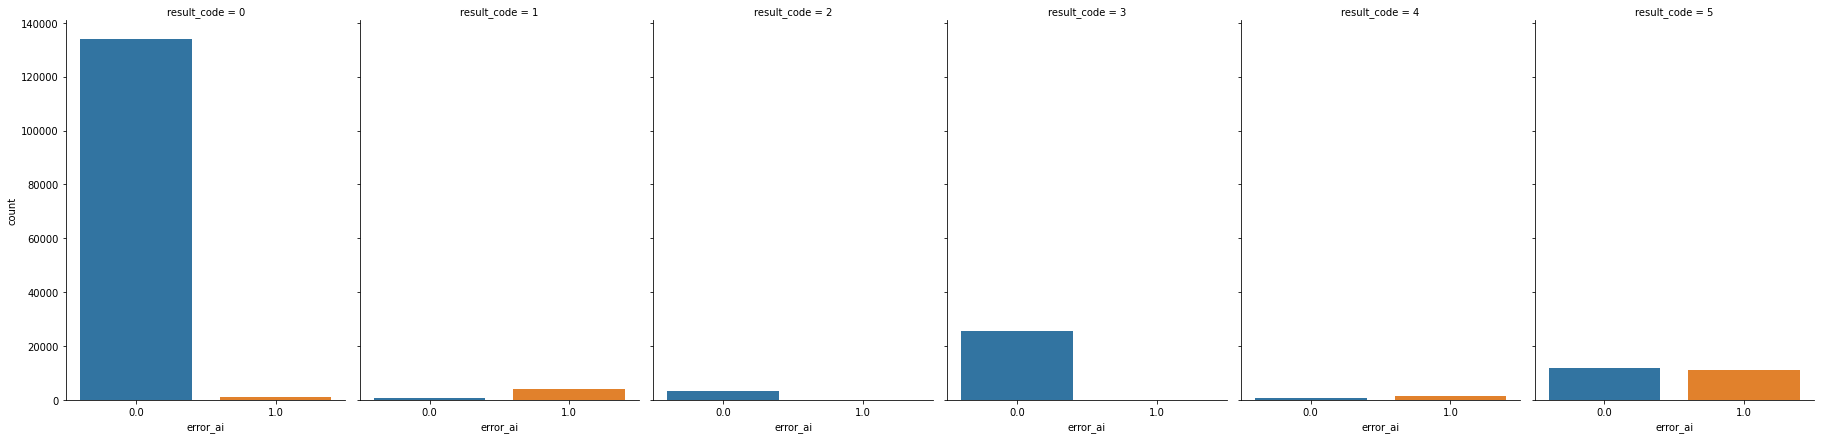

In [10]:
sns.catplot(x="error_ai", col="result_code", data=data, kind="count", height=6, aspect=0.7);

In the diagrams above, it is noticeable that the quality of the new algorithm deteriorates in case of any problems with images (result_code = 1 or 4), however, the algorithm makes much less mistakes in comparison with the operation of cameras on images that are not rejected for this reason.

Let's try to determine what factors can influence the result of recognition of the SRP by the new algorithm.

Let's see how the registration time is distributed over the hours and whether it affects on the work of the new algorithm.

###  registration time

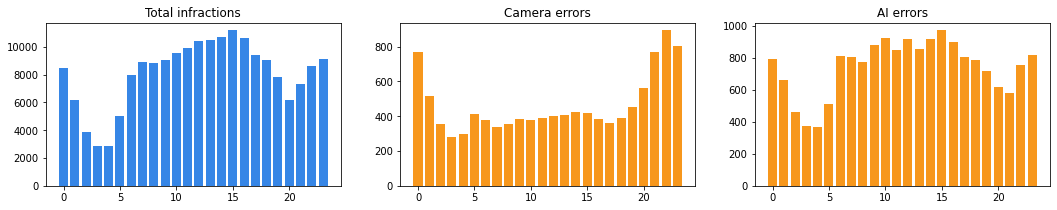

In [11]:
data['hour'] = pd.to_datetime(data['time_check']).dt.hour

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
width = 0.35  # the width of the bars
labels = [0, 1]

ax[0].bar(data['hour'].value_counts().index, data['hour'].value_counts().values, 
          color='#3686e6') 
ax[0].set(title='Total infractions')

ax[1].bar(data.loc[data['error_cam']==1]['hour'].value_counts().index, 
          data.loc[data['error_cam']==1]['hour'].value_counts().values, 
          color='#f7971c')
ax[1].set(title='Camera errors')

ax[2].bar(data.loc[data['error_ai']==1]['hour'].value_counts().index, 
          data.loc[data['error_ai']==1]['hour'].value_counts().values, 
          color='#f7971c')  
ax[2].set(title='AI errors')

plt.show()

The distribution of traffic infractions by hours visually does not differ from the general one in the case of an errors of the new algorithm, however, it is noticeable that an error in the SRP recognition by cameras at night occurs more often.

### scores

Upon closer examination, you can see that if a new algorithm makes a mistake in at least one symbol, its confidence rate in this symbol is lower than in the others (but not always!):

In [12]:
# Transformation

data['symbol_scores'] = data['symbol_scores'].apply(lambda x: x[1:-1].split(','))
data['length_scores'] = data['length_scores'].apply(lambda x: x[1:-1].split(','))
data['symbols'] = data['symbols'].apply(lambda x: x[1:-1].split(','))

In [13]:
# Example
print('SRP recognized by AI:  ', data.loc[data['error_ai']==1]['regno_ai'].iloc[0])
print('SRP recognized by operator:  ', data.loc[data['error_ai']==1]['regno'].iloc[0], '\n')

for symbol, score in zip(data.loc[data['error_ai']==1]['symbols'].iloc[0], 
                         data.loc[data['error_ai']==1]['symbol_scores'].iloc[0]):
    print(f'symbol:{symbol} -  presicion score: {round(float(score), 3)}')
print()   
for i, score in enumerate(data.loc[data['error_ai']==1]['length_scores'].iloc[0]):
    print(f'SRP lenght is {i} symbols - presicion score {round(float(score), 3)}')

SRP recognized by AI:   0037299
SRP recognized by operator:   О037799 

symbol:"0" -  presicion score: 0.964
symbol: "0" -  presicion score: 0.904
symbol: "3" -  presicion score: 0.979
symbol: "7" -  presicion score: 0.999
symbol: "2" -  presicion score: 0.437
symbol: "9" -  presicion score: 0.69
symbol: "9" -  presicion score: 0.967

SRP lenght is 0 symbols - presicion score 0.0
SRP lenght is 1 symbols - presicion score 0.0
SRP lenght is 2 symbols - presicion score 0.0
SRP lenght is 3 symbols - presicion score 0.0
SRP lenght is 4 symbols - presicion score 0.0
SRP lenght is 5 symbols - presicion score 0.0
SRP lenght is 6 symbols - presicion score 0.0
SRP lenght is 7 symbols - presicion score 0.788
SRP lenght is 8 symbols - presicion score 0.155
SRP lenght is 9 symbols - presicion score 0.055
SRP lenght is 10 symbols - presicion score 0.0


Let's add a new feature that will return the minimum confidence level in any of the recognized characters. We will act in a similar way with confidence level in the length of the SRP, in this case we are interested in its maximum value. 

In [14]:
data['symbol_min_score'] = data['symbol_scores'].apply(min_score)
data['l_max_score'] = data['length_scores'].apply(max_score)
data.head(3)

,camera_id,time_check,regno_recognize,regno_ai,regno,result_code,symbols,symbol_scores,length_scores,error_cam,error_ai,hour,symbol_min_score,l_max_score
id,,,,,,,,,,,,,,
1,844,00:00:00,У991КВ799,У991КВ799,У991КВ799,0,"[""У"", ""9"", ""9"", ""1"", ""К"", ""В"", ""7"", ""9""...","[0.9999366998672485, 0.9999223947525024, 0.9...","[0.000000034831597162110484, 0.00000003483545...",0.0,0.0,0,0.999081,0.999931
2,2516,00:00:00,О019УК177,О019УК177,О019УК177,0,"[""О"", ""0"", ""1"", ""9"", ""У"", ""К"", ""1"", ""7""...","[0.9998993873596191, 0.999862790107727, 0.99...","[0.0000000068477667980459955, 0.0000000068333...",0.0,0.0,0,0.999863,0.999990
3,2476,00:00:00,Е175АК150,Е175АК150,Е175АК150,0,"[""Е"", ""1"", ""7"", ""5"", ""А"", ""К"", ""1"", ""5""...","[0.9997256398200989, 0.9999269247055054, 0.9...","[0.000000002039653557162069, 0.00000000204338...",0.0,0.0,0,0.999726,0.999999


In [15]:
data.loc[data['error_ai']==1].describe()

,camera_id,result_code,error_cam,error_ai,hour,symbol_min_score,l_max_score
count,17863.000000,17863.000000,17863.000000,17863.0,17863.000000,17863.000000,17863.000000
mean,3969.771483,3.686279,0.080222,1.0,12.062643,0.499159,0.939177
std,2499.348364,1.889453,0.271644,0.0,6.549814,0.280223,0.121269
min,700.000000,0.000000,0.000000,1.0,0.000000,0.067891,0.355947
25%,1292.000000,1.000000,0.000000,1.0,7.000000,0.263074,0.953801
50%,4981.000000,5.000000,0.000000,1.0,12.000000,0.410309,0.997407
75%,6257.000000,5.000000,0.000000,1.0,17.000000,0.716974,0.999877
max,8898.000000,5.000000,1.000000,1.0,23.000000,0.999962,1.000000


In [16]:
data.loc[data['error_ai']==0].describe()

,camera_id,result_code,error_cam,error_ai,hour,symbol_min_score,l_max_score
count,176351.000000,176351.000000,176351.000000,176351.0,176351.000000,176351.000000,176351.000000
mean,4561.039353,0.831671,0.054879,0.0,12.506660,0.995755,0.999511
std,2500.529854,1.567388,0.227745,0.0,6.386358,0.034896,0.010460
min,700.000000,0.000000,0.000000,0.0,0.000000,0.177820,0.501335
25%,1813.000000,0.000000,0.000000,0.0,8.000000,0.999451,0.999965
50%,5781.000000,0.000000,0.000000,0.0,13.000000,0.999745,0.999985
75%,6399.000000,0.000000,0.000000,0.0,17.000000,0.999835,0.999995
max,8901.000000,5.000000,1.000000,0.0,23.000000,0.999974,1.000000


Obviously, the distribution over *min_score* quantiles is quite different. Let's build box plots for new features to look whether they are related to the error of the new algorithm.

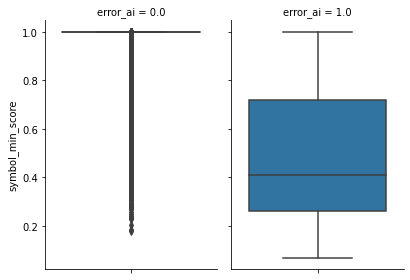

In [17]:
sns.catplot(y="symbol_min_score", col="error_ai", data=data, kind="box",  orient='v', height=4, aspect=0.7);

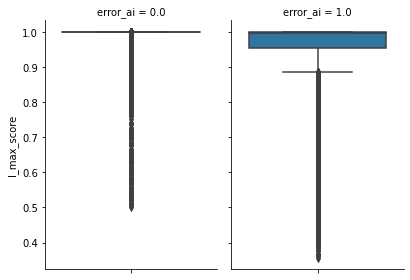

In [18]:
sns.catplot(y="l_max_score", col="error_ai", data=data, kind="box",  orient='v', height=4, aspect=0.7);

From the chart, it follows that *symbol_min_score* is highly representative indicator for predicting an algorithm error. Having chosen the threshold, it is possible to say with some accuracy whether the algorithm is wrong.

## 3. Evaluation

Data with *symbol_min_score > specified threshold* will be determined as with a correctly actuated algorithm, while data with *symbol_min_score < specified threshold* will be sent to the operator for verification.

### Threshold choice

Remember:

- class 1 - the algorithm makes mistakes
- class 0 - the algorithm does not make mistakes

In [19]:
# Let's choose threshold for start
ts = 0.990

In [20]:
# % of error that the algorithm worked correctly, but in fact it is not (and we do not know about it)

FN = data.loc[data['error_ai']==1].loc[data['symbol_min_score']>=ts]
print('False Negative: ', round((FN.shape[0]/data.shape[0])*100, 3), '% from all data')


# % of guesses when the algorithm worked incorrectly and the data needs to be rechecked by the operator

TP = data.loc[data['error_ai']==1].loc[data['symbol_min_score']<ts]
print('True Positive, to check by Operator: ', round((TP.shape[0]/data.shape[0])*100, 3), '% from all data')


# % of guesses that the algorithm worked correctly

TN = data.loc[data['error_ai']==0].loc[data['symbol_min_score']>=ts]
print('True Negative: ', round((TN.shape[0]/data.shape[0])*100, 3), '% from all data')


# % of error that the algorithm worked incorrectly, but in fact it is correct, 
# the data will be sent to the operator for rechecking also

FP = data.loc[data['error_ai']==0].loc[data['symbol_min_score']<ts]
print('False Positive, to check by Operator: ', round((FP.shape[0]/data.shape[0])*100, 3), '% from all data')

False Negative:  0.9 % from all data
True Positive, to check by Operator:  8.298 % from all data
True Negative:  88.362 % from all data
False Positive, to check by Operator:  2.44 % from all data


**Total to check by Operator:**

In [21]:
print('Total to check by Operator:' , 
      round((TP.shape[0]/data.shape[0])*100 + (FP.shape[0]/data.shape[0])*100,3),'%')

Total to check by Operator: 10.738 %


We also calculate other metrics such as precision and recall for each class and the accuarcy of the algorithm for a given threshold.

In [22]:
# Precision class 1
print('precision class 1: ', 
      round(((TP.shape[0]/data.shape[0])/((TP.shape[0]/data.shape[0])+(FP.shape[0]/data.shape[0])))*100, 3),'%')

# Recall class 1
print('recall class 1: ',
      round(((TP.shape[0]/data.shape[0])/((TP.shape[0]/data.shape[0])+(FN.shape[0]/data.shape[0])))*100,3), '%')

# Precision class 0 
print('precision class 0: ',
      round(((TN.shape[0]/data.shape[0])/((TN.shape[0]/data.shape[0])+(FN.shape[0]/data.shape[0])))*100, 3),'%')

# Recall class 0
print('recall class 0: ',\
      round(((TN.shape[0]/data.shape[0])/((TN.shape[0]/data.shape[0])+(FP.shape[0]/data.shape[0])))*100, 3),'%')

precision class 1:  77.276 %
recall class 1:  90.22 %
precision class 0:  98.992 %
recall class 0:  97.313 %


In [23]:
# Accuracy
print('accuracy: ',
      round((TP.shape[0]+TN.shape[0])/(TP.shape[0]+TN.shape[0]+FP.shape[0]+FN.shape[0])*100, 3), '%')

accuracy:  96.66 %


Classes 0 and 1 are not balanced. In this case, False Negative is more critical, as well as precision of class 0, than accuracy or other metrics, since data assigned to error class will be rechecked by operators. Let's take False Negative as the final error. In this case, for different examples of the threshold, we get the following estimates:



   threshold     | 0.990  | 0.995 | 0.999
  ------------- | -------------| -------------| -------------|
  error %   | 0.9 | 0.8  | 0.51
  % to check  | 10.7 | 11.6 | 19.3 


It will be interesting to see how the distribution of the result_code in the final algorithm error will look like:

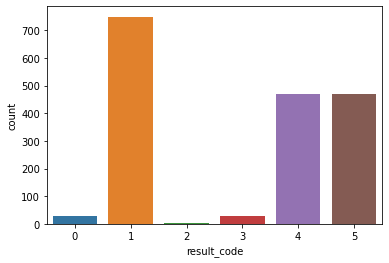

In [24]:
sns.countplot(FN['result_code']);

result_code description:
- 0 - accepted
- 1 - rejected "SRP is poorly visible"
- 2 - rejected "error in the owner's address"
- 3 - rejected "error in other data of the owner"
- 4 - rejected "poor image quality"
- 5 - rejected "other"

This means that most often the algorithm is mistaken but "does not realize it" in poor quality images.

## 4. Results

The target of the new algorithm was minimizing the labor costs of employees to replace the SRP.

1. Conditions according to which it is necessary to change the SRP from the recognized one by the camera to the one recognized by the new mathematical algorithm:

*SRP must be replaced when:*
$$min.score > threshold$$
*In other cases, the data is sent for verification to the operator*

2. The quality of the rule and the savings in replacement operations:



   threshold     | 0.99  | 0.995 | 0.999
  ------------- | -------------| -------------| -------------|
 final quality %  | 99.1 | 99.2 | 99.49
  labor costs reduction  % | 89.3 | 88.4 | 80.7 


Obviously, by changing the threshold, it is possible to regulate the balance of the desired quality and the amount of employee labor.